Data ready. Shape: (6000, 2)


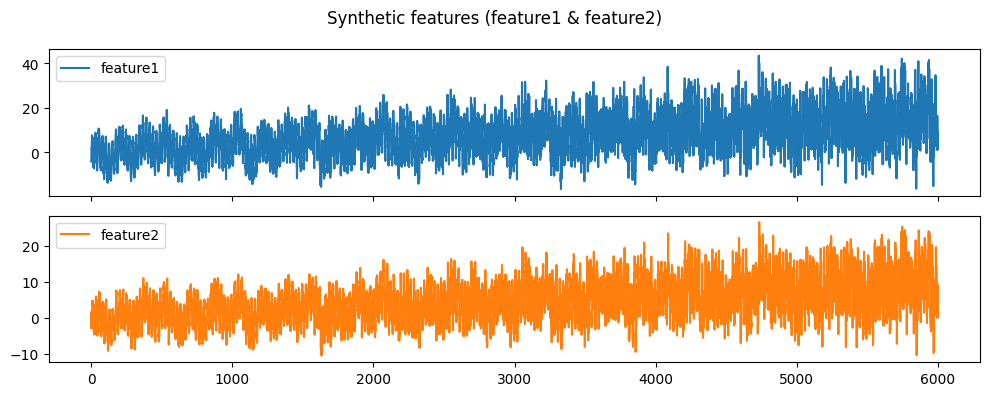

X shape: (5929, 48, 2) y shape: (5929, 24)
Train/Val/Test sizes: 4743 593 593


In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from typing import Tuple, Dict


# ---------------------------
# Utilities - Metrics
# ---------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    # protect against zero division
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# ---------------------------
# 1) Synthetic multivariate time series generation
# ---------------------------
def generate_synthetic_multivariate(n=6000, seed=42) -> pd.DataFrame:
    """
    Generate a dataset with:
    - feature1: combination of two seasonal cycles (daily + weekly), trend, and noise
    - feature2: correlated feature with additional noise
    """
    np.random.seed(seed)
    t = np.arange(n)

    # Seasonalities
    seasonal_daily = 8.0 * np.sin(2 * np.pi * t / 24)            # daily cycle
    seasonal_weekly = 4.0 * np.sin(2 * np.pi * t / 168)          # weekly cycle
    seasonal_wave = 3.0 * sawtooth(2 * np.pi * t / 540)          # long irregular cycle

    # Trend (measurable)
    trend = 0.0025 * t                                           # slow increasing trend

    # Non-stationary amplitude change (time-varying volatility)
    amplitude = 1.0 + 0.001 * t

    # Noise
    noise = np.random.normal(0, 1.2, size=n) * amplitude

    feature1 = seasonal_daily + seasonal_weekly + seasonal_wave + trend + noise

    # second feature correlated to feature1 but with its own noise and small lag
    noise2 = np.random.normal(0, 0.7, size=n)
    feature2 = 0.6 * np.roll(feature1, 3) + 0.4 * np.random.normal(0, 1.0, size=n) + noise2
    feature2[:3] = feature2[3:6]  # fix roll artifact for first few points

    df = pd.DataFrame({"feature1": feature1, "feature2": feature2})
    return df

# ---------------------------
# 2) Baseline model: Exponential Smoothing (single-step forecast repeatedly for multi-step)
# ---------------------------
def baseline_exponential_smoothing(train_series: np.ndarray, horizon: int) -> np.ndarray:
    """
    Fit ExponentialSmoothing on training series and produce horizon-step forecast.
    We will apply this rolling for each test window when needed (simple baseline).
    """
    model = ExponentialSmoothing(train_series, trend="add", seasonal=None)
    fit = model.fit(optimized=True)
    forecast = fit.forecast(horizon)
    return np.array(forecast)

# ---------------------------
# 3) Data preparation for seq2seq Transformer
# ---------------------------
def create_sequences(values: np.ndarray, input_len: int, output_len: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Construct rolling windows:
    - X shape: (num_samples, input_len, num_features)
    - y shape: (num_samples, output_len)    # predicting 1-dim target (feature1) multi-step ahead
    """
    X, y = [], []
    n = len(values)
    for start in range(n - input_len - output_len + 1):
        X.append(values[start : start + input_len])
        y.append(values[start + input_len : start + input_len + output_len, 0])  # predict feature1
    return np.array(X), np.array(y)

# ---------------------------
# 4) Transformer model (encoder-only followed by linear decoder)
# ---------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        model_dim: int = 64,
        nhead: int = 4,
        num_layers: int = 2,
        ff_dim: int = 128,
        output_len: int = 24,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.model_dim = model_dim
        # input projection
        self.input_proj = nn.Linear(input_dim, model_dim)
        # positional encoding (learned)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1000, model_dim))  # supports up to length 1000
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dim_feedforward=ff_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # decoder: from encoded sequence to required output steps (we keep it simple)
        self.fc_out = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Linear(model_dim, output_len)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len, input_dim)
        returns: (batch, output_len)
        """
        batch, seq_len, _ = x.size()
        x = self.input_proj(x)                         # -> (batch, seq_len, model_dim)
        pos = self.pos_embedding[:, :seq_len, :]       # -> (1, seq_len, model_dim)
        x = x + pos
        # Transformer expects (seq_len, batch, model_dim)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)                      # (seq_len, batch, model_dim)
        # Pool across time (simple aggregation) -> take last time-step representation
        enc_last = encoded[-1, :, :]                   # (batch, model_dim)
        out = self.fc_out(enc_last)                    # (batch, output_len)
        return out

# ---------------------------
# 5) Training and evaluation helpers
# ---------------------------
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int = 20,
    lr: float = 1e-3,
    device: str = "cpu",
):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            preds = model(xb)            # (batch, out_len)
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
        avg_train = np.mean(train_losses)

        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                val_losses.append(loss_fn(preds, yb).item())
        avg_val = np.mean(val_losses)
        history["train_loss"].append(avg_train)
        history["val_loss"].append(avg_val)

        # simple early-record
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} - train_loss: {avg_train:.6f}  val_loss: {avg_val:.6f}")

    # load best
    model.load_state_dict(best_state)
    return model, history

def evaluate_model_preds(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    y_true, y_pred shapes: (num_samples, output_len)
    We'll compute metrics on flattened arrays (all steps aggregated) and also on first step.
    """
    flat_true = y_true.ravel()
    flat_pred = y_pred.ravel()
    metrics = {
        "MAE_flat": mean_absolute_error(flat_true, flat_pred),
        "RMSE_flat": rmse(flat_true, flat_pred),
        "MAPE_flat": mape(flat_true, flat_pred),
    }
    # step-1 metrics
    metrics["MAE_step1"] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics["RMSE_step1"] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics["MAPE_step1"] = mape(y_true[:, 0], y_pred[:, 0])
    return metrics

# ---------------------------
# 6) Simple hyperparameter grid search (coarse)
# ---------------------------
def simple_hyperparameter_search(X_train, y_train, X_val, y_val, device="cpu"):
    """
    grid search over a few sensible values. Keep it small to run quickly.
    Returns the best model and best config + metrics.
    """
    # small grid
    grid = {
        "model_dim": [32, 64],
        "nhead": [2, 4],
        "num_layers": [1, 2],
        "lr": [1e-3],
        "batch_size": [32],
        "epochs": [20],
    }

    best_score = float("inf")
    best_result = None

    for model_dim in grid["model_dim"]:
        for nhead in grid["nhead"]:
            for num_layers in grid["num_layers"]:
                for lr in grid["lr"]:
                    for batch_size in grid["batch_size"]:
                        for epochs in grid["epochs"]:
                            config = dict(
                                model_dim=model_dim,
                                nhead=nhead,
                                num_layers=num_layers,
                                lr=lr,
                                batch_size=batch_size,
                                epochs=epochs,
                            )
                            print("Testing config:", config)
                            # build model
                            input_dim = X_train.shape[2]
                            out_len = y_train.shape[1]
                            model = TimeSeriesTransformer(
                                input_dim=input_dim,
                                model_dim=model_dim,
                                nhead=nhead,
                                num_layers=num_layers,
                                ff_dim=model_dim * 2,
                                output_len=out_len,
                            )
                            # dataloaders
                            train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                     torch.tensor(y_train, dtype=torch.float32))
                            val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                                   torch.tensor(y_val, dtype=torch.float32))
                            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
                            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

                            # train
                            model, _ = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, device=device)

                            # eval on val
                            model.eval()
                            with torch.no_grad():
                                val_preds = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
                            metrics = evaluate_model_preds(y_val, val_preds)
                            score = metrics["RMSE_flat"]
                            print(" -> RMSE_flat:", score)
                            if score < best_score:
                                best_score = score
                                best_result = {"config": config, "model_state": {k: v.cpu() for k, v in model.state_dict().items()}, "metrics": metrics}
    return best_result

# ---------------------------
# 7) Main execution (glue everything)
# ---------------------------
def main(device: str = "cpu"):
    # 1) Generate data
    df = generate_synthetic_multivariate(n=6000, seed=123)
    print("Data ready. Shape:", df.shape)
    df.plot(subplots=True, figsize=(10,4), title="Synthetic features (feature1 & feature2)")
    plt.tight_layout()
    plt.show()

    values = df.values
    # forecasting horizon (multi-step)
    input_len = 48       # sequence length to feed the model (configurable in grid search)
    output_len = 24      # predict 24 steps ahead
    X, y = create_sequences(values, input_len=input_len, output_len=output_len)
    print("X shape:", X.shape, "y shape:", y.shape)

    # train/val/test split (80/10/10)
    n_samples = len(X)
    train_end = int(n_samples * 0.8)
    val_end = int(n_samples * 0.9)
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))

    # 2) Baseline evaluation: Exponential Smoothing on the series (rolling forecasting)
    # We'll compute baseline predictions for the test windows: for each test sample, use training+past to forecast
    baseline_preds = []
    baseline_true = []
    # To keep it simple and deterministic, we will use the feature1 series up to the prediction point.
    # For sample i (absolute index start), the ground truth horizon corresponds to original times. We'll treat X_test sequentially.
    full_series = df["feature1"].values
    # compute starting indices for test windows
    # sample index start in original series for each X,y sample is 'start'
    # recall our create_sequences used windows from 0..n-input_len-output_len
    test_start_idx = len(values) - len(X_test) - input_len - output_len + 1
    # easier approach: iterate through last X_test by locating the corresponding absolute start
    start_indices = []
    total_windows = len(X)  # number of windows
    # absolute start for window k is k
    for k in range(val_end, total_windows):
        start_indices.append(k)
    # now for each test window perform baseline forecast with all data prior to forecast point
    for start in start_indices:
        # last known index before forecast = start + input_len - 1
        last_known_idx = start + input_len - 1
        history_series = full_series[: last_known_idx + 1]  # inclusive
        # horizon forecast
        f = baseline_exponential_smoothing(history_series, output_len)
        baseline_preds.append(f)
    baseline_preds = np.array(baseline_preds)
    baseline_true = y_test.copy()
    baseline_metrics = evaluate_model_preds(baseline_true, baseline_preds)
    print("Baseline metrics (Exponential Smoothing):", baseline_metrics)

    # 3) Hyperparameter search & Train Transformer (kept modest to run)
    # NOTE: the simple grid below is limited; increase for a full experiment
    print("\nStarting simple hyperparameter search (this may take several minutes)...")
    best = simple_hyperparameter_search(X_train, y_train, X_val, y_val, device=device)
    print("Best config:", best["config"])
    print("Best val metrics:", best["metrics"])

    # reload best model
    cfg = best["config"]
    best_model = TimeSeriesTransformer(
        input_dim=X.shape[2],
        model_dim=cfg["model_dim"],
        nhead=cfg["nhead"],
        num_layers=cfg["num_layers"],
        ff_dim=cfg["model_dim"] * 2,
        output_len=output_len,
    )
    best_model.load_state_dict(best["model_state"])

    # 4) Evaluate best model on test set
    best_model.eval()
    with torch.no_grad():
        test_preds = best_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
    test_metrics = evaluate_model_preds(y_test, test_preds)
    print("\nTransformer test metrics:", test_metrics)

    # 5) Compare baseline vs transformer on test
    print("\nComparison:")
    for key in ["MAE_flat", "RMSE_flat", "MAPE_flat"]:
        t_val = test_metrics.get(key, None)
        b_val = baseline_metrics.get(key, None)
        print(f"{key}: Transformer = {t_val:.4f} | Baseline = {b_val:.4f}")

    # 6) Plot some example forecasts (last test sample)
    num_examples = min(4, len(X_test))
    plt.figure(figsize=(12, 8))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i + 1)
        # actual sequence (input) + true future + predicted future
        seq_input = X_test[i][:, 0]          # feature1 input
        true_future = y_test[i]
        baseline_future = baseline_preds[i]
        transformer_future = test_preds[i]
        time_axis_input = np.arange(len(seq_input))
        time_axis_future = np.arange(len(seq_input), len(seq_input) + output_len)
        plt.plot(time_axis_input, seq_input, label="Input (past)", linestyle="--")
        plt.plot(time_axis_future, true_future, label="True future", marker="o")
        plt.plot(time_axis_future, baseline_future, label="Baseline forecast", marker="x")
        plt.plot(time_axis_future, transformer_future, label="Transformer forecast", marker=".")
        if i == 0:
            plt.legend()
        plt.title(f"Example forecast #{i+1}")
    plt.tight_layout()
    plt.show()

    # Save final results to CSV
    results_df = pd.DataFrame({
        "metric": ["MAE_flat", "RMSE_flat", "MAPE_flat"],
        "transformer": [test_metrics["MAE_flat"], test_metrics["RMSE_flat"], test_metrics["MAPE_flat"]],
        "baseline": [baseline_metrics["MAE_flat"], baseline_metrics["RMSE_flat"], baseline_metrics["MAPE_flat"]],
    })
    results_df.to_csv("forecast_comparison_metrics.csv", index=False)
    print("Saved forecast_comparison_metrics.csv")

    # Save the best model state
    torch.save(best_model.state_dict(), "best_transformer_ts.pth")
    print("Saved best_transformer_ts.pth")

if __name__ == "__main__":
    # choose device automatically
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    main(device=dev)
